Index
1. [Problem Statement](#1)
2. [Importing Libraries](#2)
3. [Get Data](#3)
4. [EDA](#4)
5. [Visualization](#5)
6. [Treating Skewness](#6)
7. [Scaling](#7)
8. [Relation Between Features](#8)
9. [Modeling](#9)
10.[Oops Implementation](#10)
11.[Conclusion](#11)


# Problem Statement<a id="1"></a>

Modeling of strength of high performance concrete using Machine Learning.

# Importing Libraries<a id="2"></a>

In [76]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import mean
from numpy import std
from numpy import absolute
from numpy import arange
from sklearn.model_selection import GridSearchCV

# Get Data<a id="3"></a>

In [39]:
path = os.getcwd()
files = []
for file in os.listdir():
    if file.endswith(".csv"):
        files.append(open(file))
data = pd.read_csv(files[0])        

# EDA<a id="4"></a>

In [4]:
data.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [6]:
data.isnull().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

In [5]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
lower_range = Q1-(1.5 * IQR)
upper_range = Q3 + (1.5 * IQR)
print(lower_range)
print(upper_range)

cement          -46.750
slag           -213.750
ash            -177.450
water           127.150
superplastic    -15.000
coarseagg       783.500
fineagg         577.450
age             -66.500
strength         -8.505
dtype: float64
cement           586.450
slag             356.250
ash              295.750
water            232.350
superplastic      25.000
coarseagg       1179.500
fineagg          969.050
age              129.500
strength          76.895
dtype: float64


In [35]:
def no_of_outliers(col):
    outlier = []
    colms = list(data.columns)
    index = colms.index(col)
    for x in data[col]:
        if (x>upper_range[col]) or (x<lower_range[col]):
            outlier.append(x)
    return len(outlier) 

# Visualization<a id="5"></a>

cement


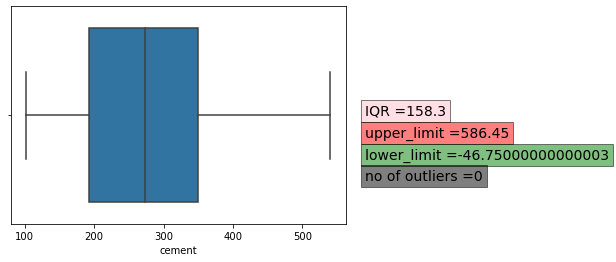

slag


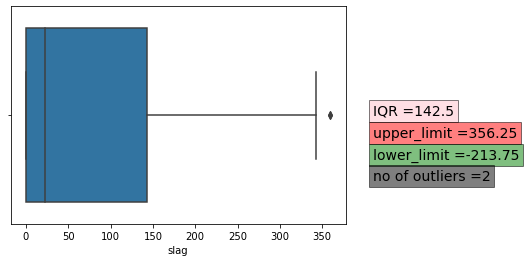

ash


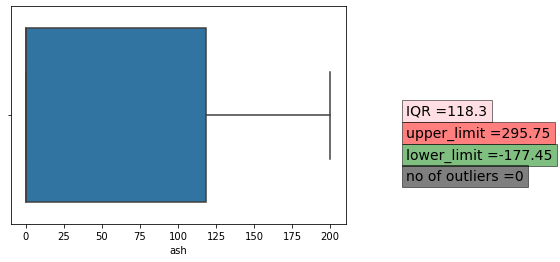

water


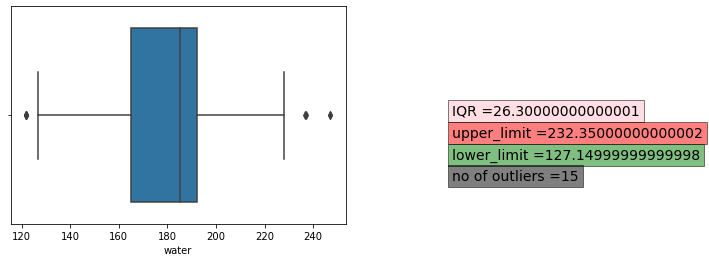

superplastic


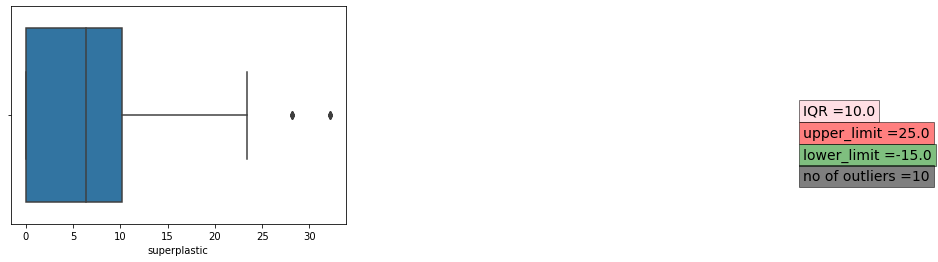

coarseagg


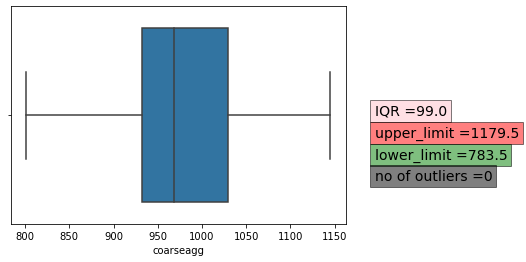

fineagg


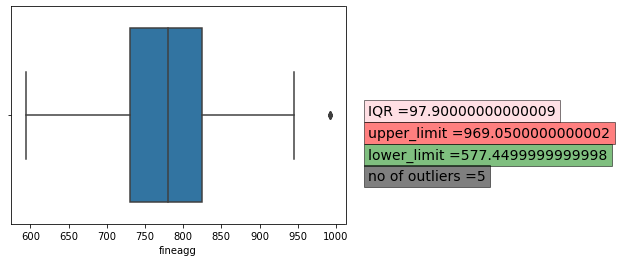

age


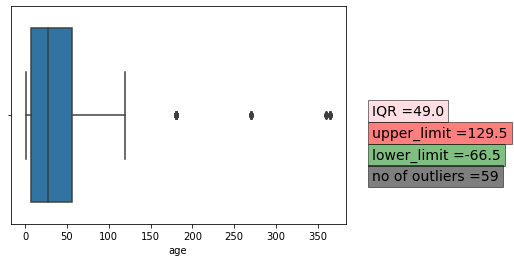

strength


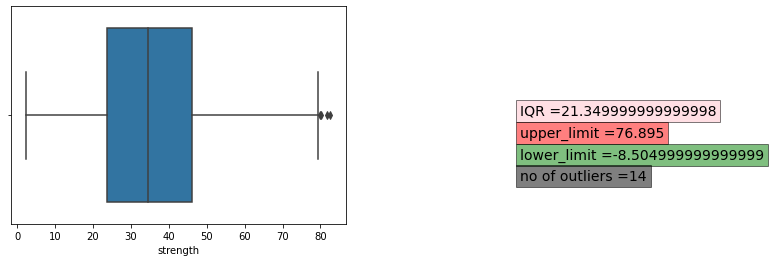

In [37]:
for i in list(data.columns):
    print(i)
    sns.boxplot(x = data[i])
    plt.text(max(data[i])+50,0, 'IQR =' + str(IQR[i]), bbox = dict(facecolor='pink',alpha=0.5),fontsize = 14)
    plt.text(max(data[i])+50,0.1, 'upper_limit =' + str(upper_range[i]), bbox = dict(facecolor='red',alpha=0.5), fontsize = 14)
    plt.text(max(data[i])+50,0.2, 'lower_limit =' + str(lower_range[i]),bbox = dict(facecolor='green',alpha=0.5), fontsize = 14)
    plt.text(max(data[i])+50,0.3, 'no of outliers =' + str(no_of_outliers(i)),bbox = dict(facecolor='black',alpha=0.5), fontsize = 14)
    #plt.text(max(data[i])+50,0.4, '% of outliers =' + str((no_of_outliers(i)/len(data[i])*100),bbox = dict(facecolor='purple',alpha=0.5), fontsize = 14))  
    plt.show()

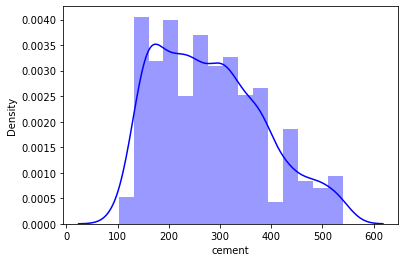

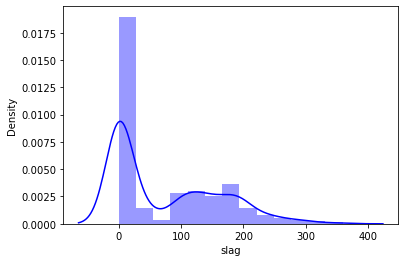

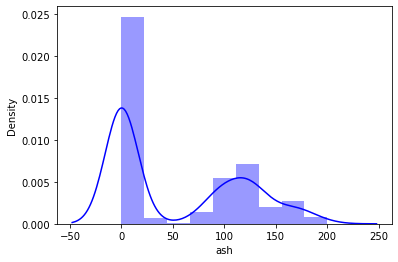

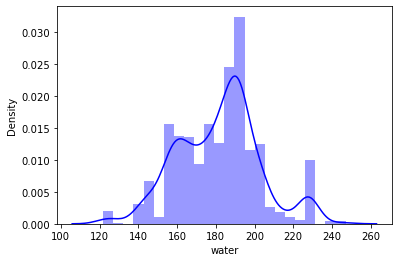

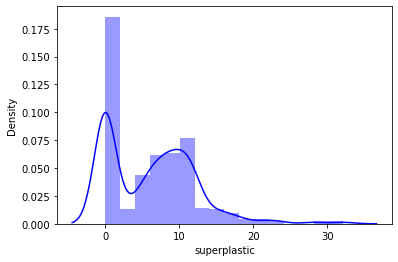

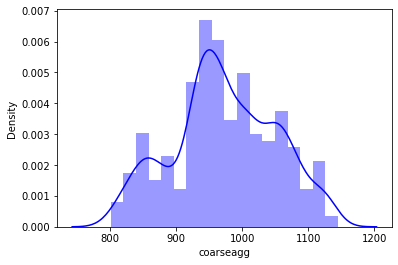

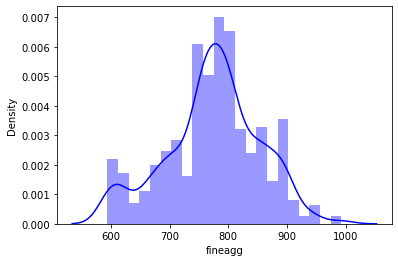

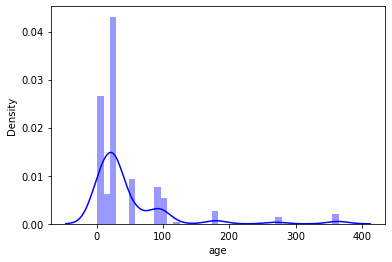

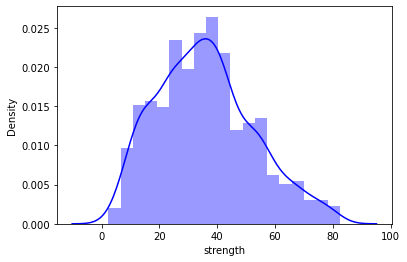

In [42]:
for i in data.columns:
    sns.distplot(data[i], color = 'b')
    plt.show()

In [12]:
data = data.drop_duplicates()
data_cleaned = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
data_cleaned.shape

(911, 9)

# Treating Skewness<a id="6"></a>

In [10]:
for i in list(data.columns):
    data_cleaned[i] = (data_cleaned[i]).transform(np.log)
   

In [13]:
#trating skewness of the data using log tranform
data_cleaned['cement'] = (data_cleaned['cement']).transform(np.log)
#df['slag'] = (df['slag']).transform(np.log)
#df['ash'] = (df['ash']).transform(np.log)
data_cleaned['water'] = (data_cleaned['water']).transform(np.log)
#df['superplastic'] = (df['superplastic']).transform(np.log)
data_cleaned['coarseagg'] = (data_cleaned['coarseagg']).transform(np.log)
data_cleaned['fineagg'] = (data_cleaned['fineagg']).transform(np.log)

# Scaling<a id="7"></a>

In [ ]:
scaler = StandardScaler()
df = scaler.fit_transform(data_cleaned) 


In [15]:
df

array([[-1.56059604,  1.63256873, -0.929175  , ..., -0.30937298,
        -0.14503281, -0.2614964 ],
       [-1.08580397, -0.3396161 ,  0.99799414, ...,  0.31063747,
        -0.63790477, -0.66418515],
       [-0.04225474, -0.82975863,  0.55457469, ...,  1.09821898,
        -0.14503281, -0.30378503],
       ...,
       [-1.68196877, -0.82975863,  1.6445183 , ...,  0.42095084,
        -0.14503281, -1.30924456],
       [ 0.22488515,  0.51755257,  0.47085214, ..., -0.04734467,
        -0.14503281,  0.6467624 ],
       [ 2.00705662, -0.82975863, -0.929175  , ..., -2.31360678,
        -0.88434075,  1.17253001]])

# Relation Between Features<a id="8"></a>

In [16]:
#getting correlation
data_cleaned.corr(method = 'pearson', min_periods=1)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
cement,1.000000,-0.330805,-0.344811,-0.073958,-0.007393,-0.051234,-0.240956,-0.037374,0.451945
slag,-0.330805,1.000000,-0.336823,0.150767,0.008096,-0.277337,-0.307140,-0.049717,0.097371
ash,-0.344811,-0.336823,1.000000,-0.294941,0.516985,-0.062372,0.086376,0.065136,-0.008966
water,-0.073958,0.150767,-0.294941,1.000000,-0.633652,-0.240801,-0.351701,-0.019614,-0.354783
superplastic,-0.007393,0.008096,0.516985,-0.633652,1.000000,-0.195546,0.097855,0.034596,0.366146
coarseagg,-0.051234,-0.277337,-0.062372,-0.240801,-0.195546,1.000000,-0.150186,0.032011,-0.149613
fineagg,-0.240956,-0.307140,0.086376,-0.351701,0.097855,-0.150186,1.000000,0.043354,-0.178796
age,-0.037374,-0.049717,0.065136,-0.019614,0.034596,0.032011,0.043354,1.000000,0.518329
strength,0.451945,0.097371,-0.008966,-0.354783,0.366146,-0.149613,-0.178796,0.518329,1.000000


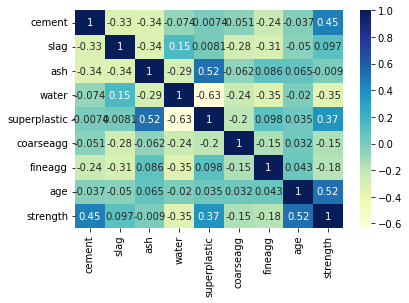

In [17]:
#visualinging correlation using heatmap
dataplot = sns.heatmap(data_cleaned.corr(), cmap ='YlGnBu', annot = True)
plt.show()

In [18]:
#selecting most important features
cor = data_cleaned.corr()
threshold = 0.5
a = abs(cor['strength'])
result = a[a>0.4]
result

cement      0.451945
age         0.518329
strength    1.000000
Name: strength, dtype: float64

In [19]:
data_cleaned[['cement', 'slag']].corr()

,cement,slag
cement,1.000000,-0.330805
slag,-0.330805,1.000000


In [21]:
data_cleaned[['strength', 'slag']].corr()

,strength,slag
strength,1.000000,0.097371
slag,0.097371,1.000000


In [22]:
data_cleaned[['strength', 'water']].corr()

,strength,water
strength,1.000000,-0.354783
water,-0.354783,1.000000


In [23]:
data_cleaned[['strength', 'age']].corr()

,strength,age
strength,1.000000,0.518329
age,0.518329,1.000000


In [25]:
data_cleaned[['strength', 'fineagg']].corr()

,strength,fineagg
strength,1.000000,-0.178796
fineagg,-0.178796,1.000000


In [26]:
data_cleaned[['strength', 'superplastic']].corr()

,strength,superplastic
strength,1.000000,0.366146
superplastic,0.366146,1.000000


In [27]:
data_cleaned[['strength', 'coarseagg']].corr()

,strength,coarseagg
strength,1.000000,-0.149613
coarseagg,-0.149613,1.000000


In [44]:
for i in data_cleaned.columns:
    a = data_cleaned[i].corr(data_cleaned.strength)
    print(f'Correlation of {i} and strength is :', a)

Correlation of cement and strength is : 0.45194526193133366
Correlation of slag and strength is : 0.09737127450742233
Correlation of ash and strength is : -0.008966427840199857
Correlation of water and strength is : -0.35478347791525383
Correlation of superplastic and strength is : 0.3661456935081276
Correlation of coarseagg and strength is : -0.14961253892895438
Correlation of fineagg and strength is : -0.17879647755471773
Correlation of age and strength is : 0.5183292501005639
Correlation of strength and strength is : 1.0


In [ ]:
data_cleaned[['strength', 'slag']].corr()

[]

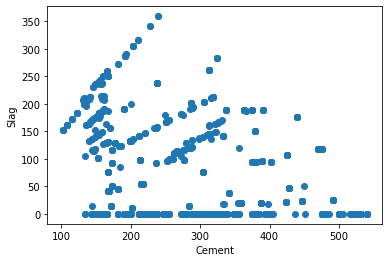

In [20]:
#Bivariate Analysis
x = data['cement']
y = data['slag']
plt.scatter(x, y)
plt.xlabel('Cement')
plt.ylabel('Slag')
plt.plot()

# Modelling<a id="9"></a>

In [45]:
X = data_cleaned.iloc[:, :8]
y = data_cleaned['strength']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

# 1.Linear Regression

In [52]:
model = LinearRegression()
model.fit(X_train, y_train)

predict = model.predict(X_test)

score = r2_score(y_test, predict)

test_score = model.score(X_test, y_test)
print(score)
print(test_score)

LinearRegression()

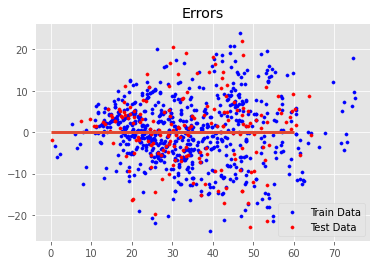

In [54]:
plt.style.use('ggplot')
plt.scatter(model.predict(X_train), model.predict(X_train)-y_train, color = "blue", s = 10, label = 'Train Data')
plt.scatter(model.predict(X_test), model.predict(X_test)-y_test, color = "red", s = 10, label = 'Test Data')
plt.hlines(y= 0, xmin = 0, xmax = 60, linewidth = 3)
plt.legend(loc = 'lower right')
plt.title("Errors")
plt.show()

In [56]:
pre = X_train.columns
coef = pd.Series(reg.coef_.flatten(),pre).sort_values()
plt.figure(figsize=(10,8))
coef.plot(kind='bar',title = 'Model Coef.', color = 'violet')
plt.show()

NameError: name 'reg' is not defined

# 2. Lasso

In [77]:
model = Lasso(alpha=1.0)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = absolute(scores)

print(mean(scores))

7.009926314606826


In [78]:
#Hyperparameter Tuning
model = Lasso()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = dict()
grid['alpha'] = arange(0,1,0.01)
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
results = search.fit(X_train, y_train)

MAE = results.best_score_
alpha = results.best_params_
print(MAE, alpha)

-6.031599273178369 {'alpha': 0.02}


# 3. Random Forest

In [63]:
from sklearn.ensemble import RandomForestRegressor
reg=RandomForestRegressor()
reg.fit(X_train,y_train.values.ravel())
pred=reg.predict(X_test)
from sklearn.metrics import r2_score
r2_score(y_test,pred)

0.8834932483287851

# 4.SVM

In [74]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X, y)
#cm_svm = confusion_matrix(y_test, svm_pred)

acc_svm = regressor.score(X_test, y_test)
acc_svm

0.287734434277206

# 5. Xgboost

In [84]:
import xgboost
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators = 300, random_state = 15)
xgb_fit = xgb.fit(X_train, y_train,)
predict = xgb.predict(X_test)
r2_score(y_test, predict)

0.8959583109184626

# After Droping features with least correlation with target feature

In [88]:
#X_new = data_cleaned.iloc[:, :8]
X_new = data_cleaned[['cement','water', 'superplastic','coarseagg', 'fineagg','age']]
y_new = data_cleaned['strength']
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, random_state = 42, test_size = 0.2)

In [89]:
model = LinearRegression()
model.fit(X_train_new, y_train_new)

predict = model.predict(X_test_new)

score = r2_score(y_test_new, predict)

test_score = model.score(X_test_new, y_test_new)
print(score)
print(test_score)

0.7220317348476264
0.7220317348476264


In [90]:
from sklearn.ensemble import RandomForestRegressor
reg=RandomForestRegressor()
reg.fit(X_train_new,y_train_new.values.ravel())
pred=reg.predict(X_test_new)
from sklearn.metrics import r2_score
r2_score(y_test_new,pred)

0.8620178543931162

# Class Implementation<a id="10"></a>

In [70]:
#
        
    

# Conclusion<a id="11"></a>

After applying several models and hypertuning , I found that Random Forest is yielding best accuracy of 88% on the given dataset.